In [48]:
import polars as pl
import matplotlib.pyplot as plt
import datetime as dt

from factor_momentum import assetspace_signal_monthly

In [49]:
start = dt.date(2000,1,1)
end = dt.date(2020,1,1)

monthly_signal = assetspace_signal_monthly(start=start, end=end, type='rolling')
monthly_signal

DEBUG: Merging....
DEBUG: Mapping....


month,barrid,ret,market_cap,signal
date,str,f64,f64,f64
2013-07-01,"""USA06Z1""",-0.001596,6.006157e8,-0.001922
2013-08-01,"""USA06Z1""",-0.014481,5.9463375e8,-0.000982
2013-09-01,"""USA06Z1""",-0.391781,4.0188375e8,-0.000542
2013-10-01,"""USA06Z1""",0.23979,5.174708e8,-0.00036
2013-11-01,"""USA06Z1""",0.172845,6.071625e8,0.000721
…,…,…,…,…
2019-12-01,"""USBEVY1""",0.038019,6.0276e8,-0.001918
2019-12-01,"""USBEWD1""",0.007976,2.0000e8,-0.001758
2019-12-01,"""USBEWE1""",-0.030714,3.6251e8,-0.001258


In [50]:
monthly_signal = (monthly_signal.with_columns(
    (pl.col('ret') * pl.col('market_cap')/pl.col('market_cap').sum().over('month')).alias('wret')
)
)

In [51]:
benchmark = monthly_signal.group_by(['month']).agg(
    pl.col('wret').mean()
).sort('month')

benchmark

month,wret
date,f64
2001-01-01,0.000018
2001-02-01,-0.00003
2001-03-01,-0.000022
2001-04-01,0.000031
2001-05-01,0.000004
…,…
2019-08-01,-0.000006
2019-09-01,0.000006
2019-10-01,0.000008


In [52]:
binned = (monthly_signal.with_columns(
    pl.col('signal').rank('dense').over('month').alias('rank')
)
.with_columns(
    (pl.lit("p") +
    (pl.col('rank')/pl.col('rank').count().over('month')*10 - 0.0001)
    .floor()
    .cast(pl.Int32).cast(pl.Utf8))
    .alias('bin')
)
.group_by(['month', 'bin']).agg(
    pl.col('ret').mean().alias('ret'),
    pl.col('wret').count().alias('count'),
    pl.col('market_cap').sum()
)
.sort(['bin', 'month'])
.with_columns(
    (pl.col('ret') * pl.col('market_cap') / pl.col('market_cap').sum().over('month')).alias('wret')
)
)

ports_ew = (binned
.pivot(on='bin', index='month', values='ret')
.drop_nulls()
)

ports_vw = (binned
.pivot(on='bin', index='month', values='wret')
.drop_nulls()
)

ports_vw

month,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2001-01-01,0.007565,0.027212,0.017806,0.015914,0.005527,0.005669,0.004117,0.003102,0.002725,0.001701
2001-02-01,-0.002993,-0.00941,-0.026111,-0.031346,-0.013706,-0.005646,-0.001969,-0.001431,0.000124,0.000675
2001-03-01,-0.001448,-0.003751,-0.011374,-0.012699,-0.010089,-0.007689,-0.004431,-0.002135,-0.001838,-0.000649
2001-04-01,0.00004,0.008376,0.026859,0.032018,0.012117,0.005657,0.00386,0.003407,0.002259,0.001363
2001-05-01,-0.000055,-0.001102,0.001532,-0.00287,0.005481,0.002876,0.00157,0.001509,0.001032,0.000404
…,…,…,…,…,…,…,…,…,…,…
2019-08-01,-0.001553,-0.00135,-0.001575,-0.00212,-0.002345,-0.003518,-0.002959,-0.003175,-0.003383,0.008098
2019-09-01,0.000142,0.000113,0.000247,0.000503,0.000612,0.001468,0.001473,0.002892,0.003934,0.004961
2019-10-01,-0.00025,-0.000164,0.000161,0.000384,0.000555,0.001336,0.001833,0.002038,0.006614,0.002201


In [53]:
def plot_deciles(df, name, cum_sum=True):
    plt.figure(figsize=(8, 5))
    plt.title(name)
    dates = df['month']

    for i in range(10):
        if cum_sum:
            plt.plot(dates, df[f'p{i}'].cum_sum(),label = f'p{i}')
        else:
            plt.plot(dates, df[f'p{i}'],label = f'p{i}')
            
    plt.legend()
    plt.show()

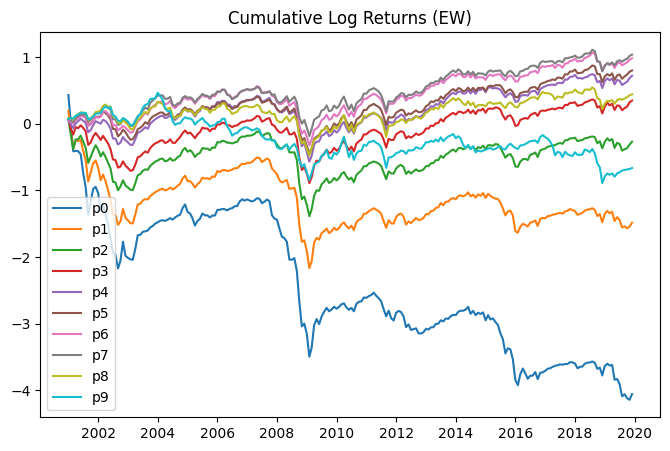

In [54]:
plot_deciles(ports_ew, "Cumulative Log Returns (EW)")

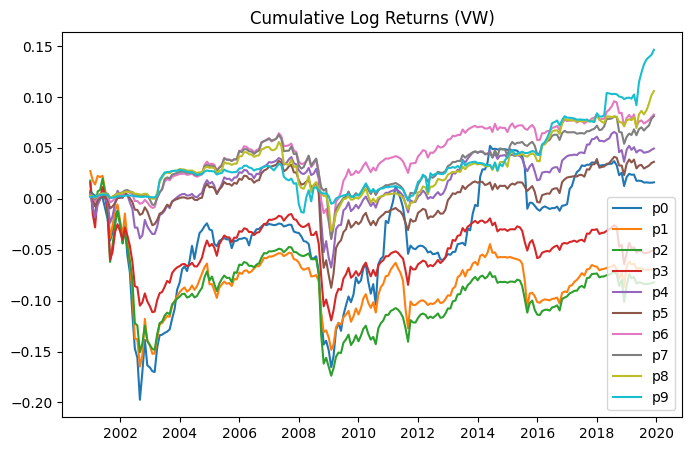

In [55]:
plot_deciles(ports_vw, "Cumulative Log Returns (VW)")

In [56]:
mes = (binned
.pivot(on='bin', index='month', values='market_cap')
.drop_nulls()
)

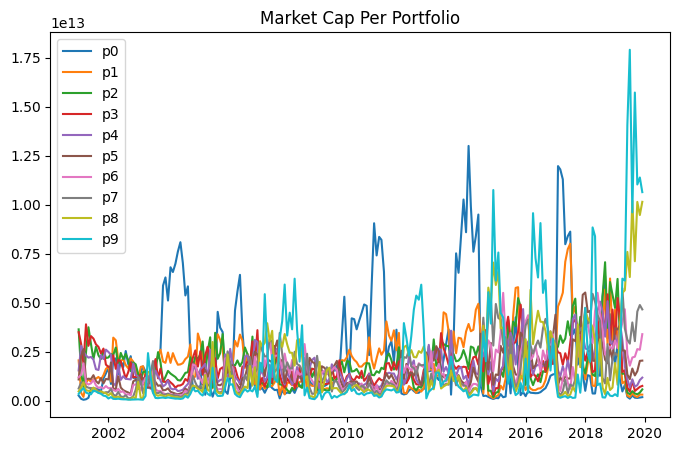

In [60]:
plot_deciles(mes, 'Market Cap Per Portfolio', False)

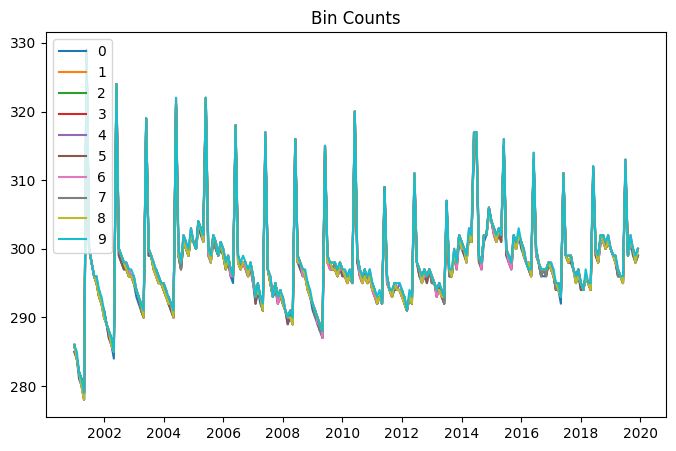

In [58]:
dates = ports_vw['month']
counts = (binned.pivot(
    on='bin', index='month', values='count'
)
)

plt.figure(figsize=(8, 5))
plt.title("Bin Counts")

for i in range(10):
    plt.plot(dates, counts[f'p{i}'], label = f'{i}')

plt.legend()
plt.show()

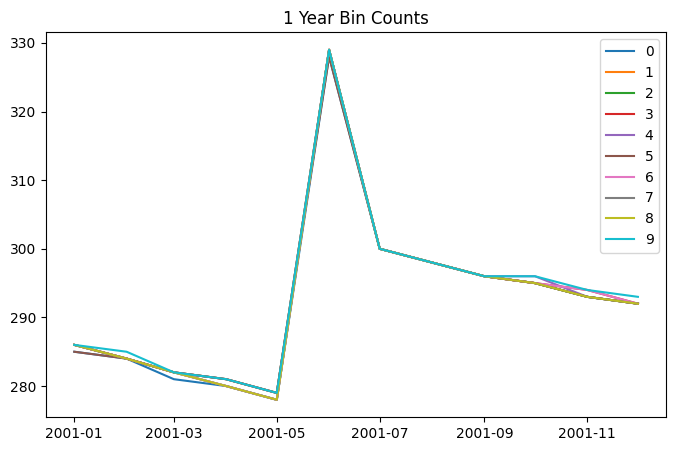

In [59]:
plt.figure(figsize=(8, 5))
plt.title("1 Year Bin Counts")

for i in range(10):
    plt.plot(dates[:12], counts[f'p{i}'][:12], label = f'{i}')

plt.legend()
plt.show()